In [16]:
%load_ext autoreload
%autoreload 2

import os
import time

import numpy as np

from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torchvision.datasets.vision import VisionDataset
from torch.utils.data import DataLoader
from torchvision import transforms


from datasets import BadNetsDataset, WaNetDataset, SIGDataset
from simclr import SimClrBackbone

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
device = "cuda"
epochs = 300
batch_size = 128

In [18]:
LOAD_CHECKPOINT = True
CHECKPOINT_NAME = "SimCLR_240.pt"

DATASET = "sig"

if DATASET == "badnets":
    TARGET_CLASS = 1
elif DATASET == "wanet":
    TARGET_CLASS = 0
elif DATASET == "sig":
    TARGET_CLASS = 0
else:
    raise Exception("Invalid dataset")

## Poison dataset

In [19]:
dataset = torchvision.datasets.CIFAR10(root='C:/Datasets', train=True, download=True)

if DATASET == "badnets":
    poison_dataset = BadNetsDataset(dataset, TARGET_CLASS, "triggers/trigger_10.png", seed=1)
elif DATASET == "wanet":
    poison_dataset = WaNetDataset(dataset, TARGET_CLASS, seed=1)
elif DATASET == "sig":
    poison_dataset = SIGDataset(dataset, TARGET_CLASS, 20, 6, seed=1)
else:
    raise Exception("Invalid dataset")

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


## SimCLR data augmentations

In [20]:
class ConstrastiveDataset(VisionDataset):

    def __init__(self, original_dataset: VisionDataset, s: int = 0.5):
        self.original_dataset = original_dataset

        self.transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomResizedCrop(32,(0.8,1.0),antialias=False),
            transforms.Compose([transforms.RandomApply([
                transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)], p = 0.8),
                transforms.RandomGrayscale(p=0.2)]),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
            ])
    
    def __len__(self):
        return len(self.original_dataset)
    
    def __getitem__(self, index):
        img = self.original_dataset[index][0]
        augmented_img_1 = self.transforms(img)
        augmented_img_2 = self.transforms(img)
        return augmented_img_1, augmented_img_2
    
constrastive_dataset = ConstrastiveDataset(poison_dataset)

## SimCLR model

In [21]:
model = SimClrBackbone()
model = model.to(device)

c:\Users\Luka\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Luka\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## LARS optimizer

In [22]:
from torch.optim.optimizer import Optimizer, required
import re

EETA_DEFAULT = 0.001


class LARS(Optimizer):
    """
    Layer-wise Adaptive Rate Scaling for large batch training.
    Introduced by "Large Batch Training of Convolutional Networks" by Y. You,
    I. Gitman, and B. Ginsburg. (https://arxiv.org/abs/1708.03888)
    """

    def __init__(
        self,
        params,
        lr=required,
        momentum=0.9,
        use_nesterov=False,
        weight_decay=0.0,
        exclude_from_weight_decay=None,
        exclude_from_layer_adaptation=None,
        classic_momentum=True,
        eeta=EETA_DEFAULT,
    ):
        """Constructs a LARSOptimizer.
        Args:
        lr: A `float` for learning rate.
        momentum: A `float` for momentum.
        use_nesterov: A 'Boolean' for whether to use nesterov momentum.
        weight_decay: A `float` for weight decay.
        exclude_from_weight_decay: A list of `string` for variable screening, if
            any of the string appears in a variable's name, the variable will be
            excluded for computing weight decay. For example, one could specify
            the list like ['batch_normalization', 'bias'] to exclude BN and bias
            from weight decay.
        exclude_from_layer_adaptation: Similar to exclude_from_weight_decay, but
            for layer adaptation. If it is None, it will be defaulted the same as
            exclude_from_weight_decay.
        classic_momentum: A `boolean` for whether to use classic (or popular)
            momentum. The learning rate is applied during momeuntum update in
            classic momentum, but after momentum for popular momentum.
        eeta: A `float` for scaling of learning rate when computing trust ratio.
        name: The name for the scope.
        """

        self.epoch = 0
        defaults = dict(
            lr=lr,
            momentum=momentum,
            use_nesterov=use_nesterov,
            weight_decay=weight_decay,
            exclude_from_weight_decay=exclude_from_weight_decay,
            exclude_from_layer_adaptation=exclude_from_layer_adaptation,
            classic_momentum=classic_momentum,
            eeta=eeta,
        )

        super(LARS, self).__init__(params, defaults)
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.use_nesterov = use_nesterov
        self.classic_momentum = classic_momentum
        self.eeta = eeta
        self.exclude_from_weight_decay = exclude_from_weight_decay
        # exclude_from_layer_adaptation is set to exclude_from_weight_decay if the
        # arg is None.
        if exclude_from_layer_adaptation:
            self.exclude_from_layer_adaptation = exclude_from_layer_adaptation
        else:
            self.exclude_from_layer_adaptation = exclude_from_weight_decay

    def step(self, epoch=None, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        if epoch is None:
            epoch = self.epoch
            self.epoch += 1

        for group in self.param_groups:
            weight_decay = group["weight_decay"]
            momentum = group["momentum"]
            eeta = group["eeta"]
            lr = group["lr"]

            for p in group["params"]:
                if p.grad is None:
                    continue

                param = p.data
                grad = p.grad.data

                param_state = self.state[p]

                # TODO: get param names
                # if self._use_weight_decay(param_name):
                grad += self.weight_decay * param

                if self.classic_momentum:
                    trust_ratio = 1.0

                    # TODO: get param names
                    # if self._do_layer_adaptation(param_name):
                    w_norm = torch.norm(param)
                    g_norm = torch.norm(grad)

                    device = g_norm.get_device()
                    trust_ratio = torch.where(
                        w_norm.gt(0),
                        torch.where(
                            g_norm.gt(0),
                            (self.eeta * w_norm / g_norm),
                            torch.Tensor([1.0]).to(device),
                        ),
                        torch.Tensor([1.0]).to(device),
                    ).item()

                    scaled_lr = lr * trust_ratio
                    if "momentum_buffer" not in param_state:
                        next_v = param_state["momentum_buffer"] = torch.zeros_like(
                            p.data
                        )
                    else:
                        next_v = param_state["momentum_buffer"]

                    next_v.mul_(momentum).add_(scaled_lr, grad)
                    if self.use_nesterov:
                        update = (self.momentum * next_v) + (scaled_lr * grad)
                    else:
                        update = next_v

                    p.data.add_(-update)
                else:
                    raise NotImplementedError

        return loss

    def _use_weight_decay(self, param_name):
        """Whether to use L2 weight decay for `param_name`."""
        if not self.weight_decay:
            return False
        if self.exclude_from_weight_decay:
            for r in self.exclude_from_weight_decay:
                if re.search(r, param_name) is not None:
                    return False
        return True

    def _do_layer_adaptation(self, param_name):
        """Whether to do layer-wise learning rate adaptation for `param_name`."""
        if self.exclude_from_layer_adaptation:
            for r in self.exclude_from_layer_adaptation:
                if re.search(r, param_name) is not None:
                    return False
        return True

## SimCLR contrastive loss

In [23]:
class SimCLR_Loss(nn.Module):
    def __init__(self, temperature):
        super(SimCLR_Loss, self).__init__()
        self.temperature = temperature

        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
            
        return mask

    def forward(self, z_i, z_j):
        """
        We do not sample negative examples explicitly.
        Instead, given a positive pair, similar to (Chen et al., 2017), we treat the other 2(N − 1) augmented examples within a minibatch as negative examples.
        """
        batch_size = z_i.shape[0]
        mask = self.mask_correlated_samples(batch_size)

        N = 2 * batch_size #* self.world_size
        
        #z_i_ = z_i / torch.sqrt(torch.sum(torch.square(z_i),dim = 1, keepdim = True))
        #z_j_ = z_j / torch.sqrt(torch.sum(torch.square(z_j),dim = 1, keepdim = True))

        z = torch.cat((z_i, z_j), dim=0)

        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature
        
        #print(sim.shape)

        sim_i_j = torch.diag(sim, batch_size)
        sim_j_i = torch.diag(sim, batch_size)
        
        
        # We have 2N samples, but with Distributed training every GPU gets N examples too, resulting in: 2xNxN
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[mask].reshape(N, -1)
        
        
        #SIMCLR
        labels = torch.from_numpy(np.array([0]*N)).reshape(-1).to(positive_samples.device).long() #.float()
        #labels was torch.zeros(N)
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N
        
        return loss

## Training

In [24]:
optimizer = LARS(
    [params for params in model.parameters() if params.requires_grad],
    lr=0.2,
    weight_decay=1e-6,
    exclude_from_weight_decay=["batch_normalization", "bias"],
)

# "decay the learning rate with the cosine decay schedule without restarts"
warmupscheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch : (epoch+1)/10.0, verbose = False)
mainscheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 500, eta_min=0.05, last_epoch=-1, verbose = False)

criterion = SimCLR_Loss(temperature=0.5)

dataloader = DataLoader(constrastive_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
dataloader_no_contrastive = DataLoader(poison_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

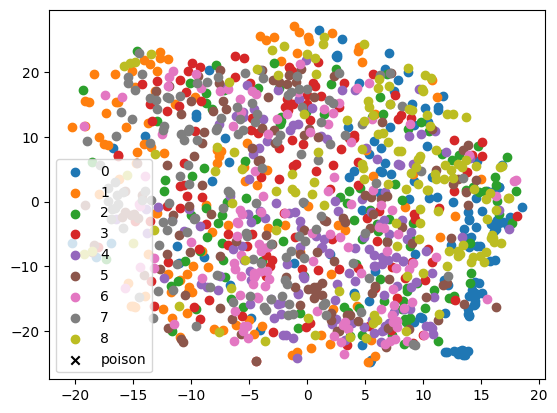

In [25]:
from sklearn.manifold import TSNE

def plot_features(model: nn.Module, dataloader: DataLoader, batches: int = None):
    model.eval()

    features = None
    labels_poison = None
    labels_true = None

    for i, (img, labels_batch_poison, labels_batch_true) in enumerate(dataloader):

        if batches is not None and i>=batches:
            break
    
        with torch.no_grad():
            features_batch = model(img.to(device)).cpu().data.numpy()
            
        if features is None:
            features = features_batch
            labels_poison = labels_batch_poison
            labels_true = labels_batch_true
        else:
            features = np.append(features, features_batch, axis=0)
            labels_poison = np.append(labels_poison, labels_batch_poison, axis=0)
            labels_true = np.append(labels_true, labels_batch_true, axis=0)
    
    tsne = TSNE(n_components = 2, perplexity = 50)
    tsne_features = tsne.fit_transform(features)
    num_classes = max(labels_batch_poison)

    labels = labels_true
    labels[labels_true != labels_poison] = 10

    for i in range(num_classes):
        plt.scatter(tsne_features[labels==i,1], tsne_features[labels==i,0])
    plt.scatter(tsne_features[labels==10,1], tsne_features[labels==10,0], c = "black", marker= "x")

    plt.legend([str(i) for i in range(num_classes)] + ["poison"])
    plt.show()

    model.train()

plot_features(model, dataloader_no_contrastive, 10)

In [26]:
def train(dataloader, model, criterion, optimizer):
    loss_epoch = 0
    
    for step, (x_i, x_j) in enumerate(dataloader):
        optimizer.zero_grad()
        x_i = x_i.to(device).float()
        x_j = x_j.to(device).float()

        # positive pair, with encoding
        z_i = model(x_i)
        z_j = model(x_j)

        loss = criterion(z_i, z_j)
        loss.backward()

        optimizer.step()
        
        if step % 50 == 0:
            print(f"\tStep [{step}/{len(dataloader)}]\t Loss: {round(loss.item(), 5)}")

        loss_epoch += loss.item()
    return loss_epoch / len(dataloader)

In [27]:
def save_model(model, optimizer, scheduler, epoch, name):
    out = os.path.join('./saved_models/', name)

    torch.save({'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'epoch': epoch
                }, out)

    print(f"\tSaved model, optimizer, scheduler and epoch info to {out}")

In [28]:
start_epoch = 0

load_checkpoint = False
checkpoint_name = "WaNet-SimCLR_150.pt"

if LOAD_CHECKPOINT:
    out = os.path.join('./saved_models/', CHECKPOINT_NAME)
    checkpoint = torch.load(out, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    mainscheduler.load_state_dict(checkpoint["scheduler_state_dict"])
    start_epoch = checkpoint["epoch"] + 1

Epoch [241/300]	
	Step [0/391]	 Loss: 3.58766
	Step [50/391]	 Loss: 3.586
	Step [100/391]	 Loss: 3.58452
	Step [150/391]	 Loss: 3.59125
	Step [200/391]	 Loss: 3.58893
	Step [250/391]	 Loss: 3.59532
	Step [300/391]	 Loss: 3.58653
	Step [350/391]	 Loss: 3.59158

	Training Loss: 3.5876123472247894
	Time Taken: 4.168611379464467 minutes
Epoch [242/300]	
	Step [0/391]	 Loss: 3.59312
	Step [50/391]	 Loss: 3.59468
	Step [100/391]	 Loss: 3.58707
	Step [150/391]	 Loss: 3.58923
	Step [200/391]	 Loss: 3.58683
	Step [250/391]	 Loss: 3.58358
	Step [300/391]	 Loss: 3.58547
	Step [350/391]	 Loss: 3.59267

	Training Loss: 3.587257489523924
	Time Taken: 4.120770370960235 minutes
Epoch [243/300]	
	Step [0/391]	 Loss: 3.58546
	Step [50/391]	 Loss: 3.58982
	Step [100/391]	 Loss: 3.58595
	Step [150/391]	 Loss: 3.58575
	Step [200/391]	 Loss: 3.59024
	Step [250/391]	 Loss: 3.58895
	Step [300/391]	 Loss: 3.58975
	Step [350/391]	 Loss: 3.59157

	Training Loss: 3.5872310793308344
	Time Taken: 4.195823605855306 

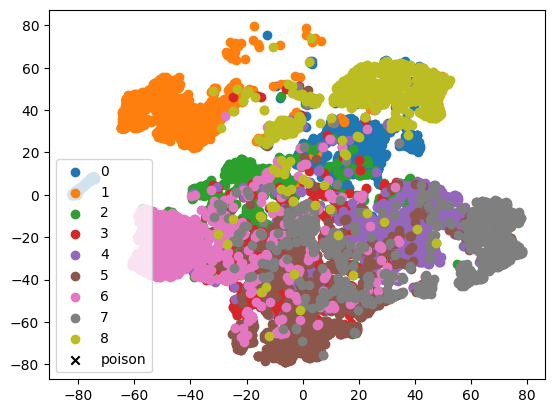

Epoch [251/300]	
	Step [0/391]	 Loss: 3.59059
	Step [50/391]	 Loss: 3.58754
	Step [100/391]	 Loss: 3.58716
	Step [150/391]	 Loss: 3.59305
	Step [200/391]	 Loss: 3.59045
	Step [250/391]	 Loss: 3.58855
	Step [300/391]	 Loss: 3.58585
	Step [350/391]	 Loss: 3.58887

	Training Loss: 3.5868282970565053
	Time Taken: 3.6093652129173277 minutes
Epoch [252/300]	
	Step [0/391]	 Loss: 3.58613
	Step [50/391]	 Loss: 3.58705
	Step [100/391]	 Loss: 3.58284
	Step [150/391]	 Loss: 3.58599
	Step [200/391]	 Loss: 3.58216
	Step [250/391]	 Loss: 3.58384
	Step [300/391]	 Loss: 3.58992
	Step [350/391]	 Loss: 3.59051

	Training Loss: 3.586737901658353
	Time Taken: 3.60665549437205 minutes
Epoch [253/300]	
	Step [0/391]	 Loss: 3.59268
	Step [50/391]	 Loss: 3.58738
	Step [100/391]	 Loss: 3.58673
	Step [150/391]	 Loss: 3.58933
	Step [200/391]	 Loss: 3.58729
	Step [250/391]	 Loss: 3.5898
	Step [300/391]	 Loss: 3.58718
	Step [350/391]	 Loss: 3.58967

	Training Loss: 3.5868298623263075
	Time Taken: 3.602868012587229

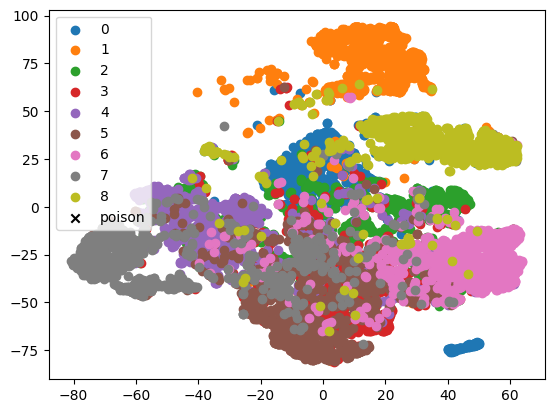

Epoch [261/300]	
	Step [0/391]	 Loss: 3.58351
	Step [50/391]	 Loss: 3.59051
	Step [100/391]	 Loss: 3.58946
	Step [150/391]	 Loss: 3.5859
	Step [200/391]	 Loss: 3.58806
	Step [250/391]	 Loss: 3.58977
	Step [300/391]	 Loss: 3.58485
	Step [350/391]	 Loss: 3.58843

	Training Loss: 3.5860698741415273
	Time Taken: 3.61083193620046 minutes
Epoch [262/300]	
	Step [0/391]	 Loss: 3.58586
	Step [50/391]	 Loss: 3.58845
	Step [100/391]	 Loss: 3.58421
	Step [150/391]	 Loss: 3.58948
	Step [200/391]	 Loss: 3.58838
	Step [250/391]	 Loss: 3.5873
	Step [300/391]	 Loss: 3.59001
	Step [350/391]	 Loss: 3.5882

	Training Loss: 3.5862060209064532
	Time Taken: 3.6056779901186626 minutes
Epoch [263/300]	
	Step [0/391]	 Loss: 3.5852
	Step [50/391]	 Loss: 3.58895
	Step [100/391]	 Loss: 3.58221
	Step [150/391]	 Loss: 3.58873
	Step [200/391]	 Loss: 3.58874
	Step [250/391]	 Loss: 3.58162
	Step [300/391]	 Loss: 3.58785
	Step [350/391]	 Loss: 3.58802

	Training Loss: 3.586050484186548
	Time Taken: 3.5914203763008117 m

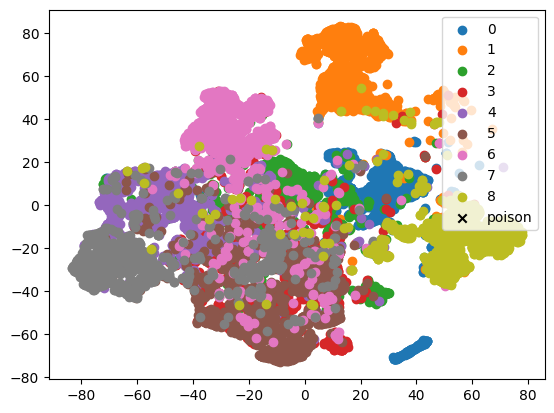

Epoch [271/300]	
	Step [0/391]	 Loss: 3.5827
	Step [50/391]	 Loss: 3.58983
	Step [100/391]	 Loss: 3.58692
	Step [150/391]	 Loss: 3.58432
	Step [200/391]	 Loss: 3.58613
	Step [250/391]	 Loss: 3.5842
	Step [300/391]	 Loss: 3.58458
	Step [350/391]	 Loss: 3.58315

	Training Loss: 3.585783512695976
	Time Taken: 3.758669861157735 minutes
Epoch [272/300]	
	Step [0/391]	 Loss: 3.58956
	Step [50/391]	 Loss: 3.57938
	Step [100/391]	 Loss: 3.5865
	Step [150/391]	 Loss: 3.585
	Step [200/391]	 Loss: 3.58763
	Step [250/391]	 Loss: 3.58378
	Step [300/391]	 Loss: 3.58887
	Step [350/391]	 Loss: 3.58584

	Training Loss: 3.5852643608132286
	Time Taken: 3.693953029314677 minutes
Epoch [273/300]	
	Step [0/391]	 Loss: 3.59067
	Step [50/391]	 Loss: 3.59267
	Step [100/391]	 Loss: 3.58698
	Step [150/391]	 Loss: 3.58845
	Step [200/391]	 Loss: 3.58414
	Step [250/391]	 Loss: 3.59164
	Step [300/391]	 Loss: 3.59072
	Step [350/391]	 Loss: 3.58518

	Training Loss: 3.5853580922421897
	Time Taken: 3.672119887669881 min

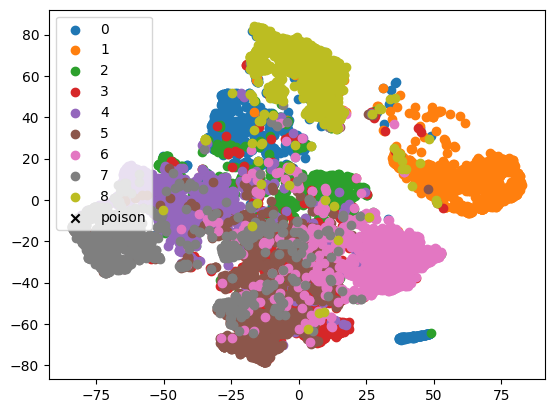

Epoch [281/300]	
	Step [0/391]	 Loss: 3.58384
	Step [50/391]	 Loss: 3.58174
	Step [100/391]	 Loss: 3.58347
	Step [150/391]	 Loss: 3.5871
	Step [200/391]	 Loss: 3.58539
	Step [250/391]	 Loss: 3.58748
	Step [300/391]	 Loss: 3.58995
	Step [350/391]	 Loss: 3.58873

	Training Loss: 3.5847696221393086
	Time Taken: 3.696070444583893 minutes
Epoch [282/300]	
	Step [0/391]	 Loss: 3.58505
	Step [50/391]	 Loss: 3.58933
	Step [100/391]	 Loss: 3.58778
	Step [150/391]	 Loss: 3.58811
	Step [200/391]	 Loss: 3.5878
	Step [250/391]	 Loss: 3.58461
	Step [300/391]	 Loss: 3.58467
	Step [350/391]	 Loss: 3.5816

	Training Loss: 3.5849257637472713
	Time Taken: 3.693437087535858 minutes
Epoch [283/300]	
	Step [0/391]	 Loss: 3.58965
	Step [50/391]	 Loss: 3.58276
	Step [100/391]	 Loss: 3.58825
	Step [150/391]	 Loss: 3.5872
	Step [200/391]	 Loss: 3.58585
	Step [250/391]	 Loss: 3.58364
	Step [300/391]	 Loss: 3.58333
	Step [350/391]	 Loss: 3.58225

	Training Loss: 3.5848605809614176
	Time Taken: 3.6833309610684712 

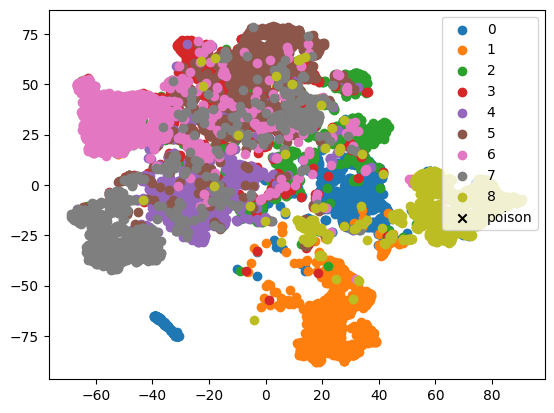

Epoch [291/300]	
	Step [0/391]	 Loss: 3.58564
	Step [50/391]	 Loss: 3.58701
	Step [100/391]	 Loss: 3.58729
	Step [150/391]	 Loss: 3.5843
	Step [200/391]	 Loss: 3.59007
	Step [250/391]	 Loss: 3.58649
	Step [300/391]	 Loss: 3.58447
	Step [350/391]	 Loss: 3.58826

	Training Loss: 3.5845485068952945
	Time Taken: 3.707786504427592 minutes
Epoch [292/300]	
	Step [0/391]	 Loss: 3.58416
	Step [50/391]	 Loss: 3.58939
	Step [100/391]	 Loss: 3.58917
	Step [150/391]	 Loss: 3.586
	Step [200/391]	 Loss: 3.58697
	Step [250/391]	 Loss: 3.58558
	Step [300/391]	 Loss: 3.58525
	Step [350/391]	 Loss: 3.5857

	Training Loss: 3.5841888539931355
	Time Taken: 3.7070036848386128 minutes
Epoch [293/300]	
	Step [0/391]	 Loss: 3.58395
	Step [50/391]	 Loss: 3.58572
	Step [100/391]	 Loss: 3.5822
	Step [150/391]	 Loss: 3.58586
	Step [200/391]	 Loss: 3.58247
	Step [250/391]	 Loss: 3.5837
	Step [300/391]	 Loss: 3.5836
	Step [350/391]	 Loss: 3.58318

	Training Loss: 3.5842844519163948
	Time Taken: 3.6836371779441834 mi

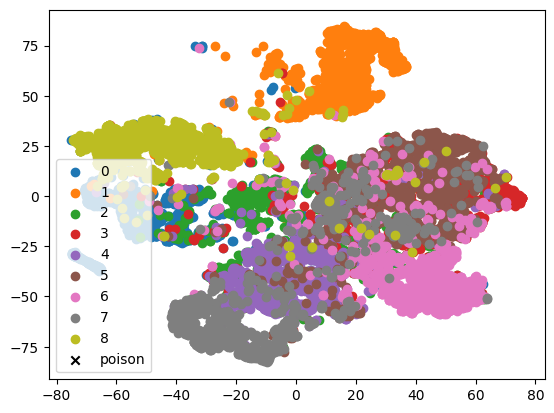

	Saved model, optimizer, scheduler and epoch info to ./saved_models/NEW-SimCLR.pt


In [29]:
losses = []

for epoch in range(start_epoch, epochs+1):
    print(f"Epoch [{epoch}/{epochs}]\t")
    stime = time.time()

    model.train()
    loss = train(dataloader, model, criterion, optimizer)
    losses.append(loss)

    if epoch <= 10:
        warmupscheduler.step()
    if epoch > 10:
        mainscheduler.step()
    
    print()
    print(f"\tTraining Loss: {loss}")
    time_taken = (time.time()-stime)/60
    print(f"\tTime Taken: {time_taken} minutes")

    if (epoch) % 10 == 0:
        save_model(model, optimizer, mainscheduler, epoch, "NEW-SimCLR.pt")
        plot_features(model, dataloader_no_contrastive, 100)

## end training
save_model(model, optimizer, mainscheduler, epochs, "NEW-SimCLR.pt")